In [32]:
import os

current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)
analyze_path = os.path.join(parent_dir, "utils")

os.chdir(analyze_path)

In [33]:
import joblib
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, roc_auc_score

import torch
from sklearn.model_selection import GridSearchCV
from utils_nn import BinaryMLP, train_neural_network, predict_nn
from utils_model import model_preprocess, print_results, get_importance

version = "V1"
computeddata = 'ComputedDataV6'

from imblearn.under_sampling import RandomUnderSampler

In [34]:
final_grid_features = pd.read_csv('../ComputedDataV6/ForModel/final_grid_features.csv')
dom_cols = [c for c in final_grid_features.columns if c.endswith('_dom')]
final_grid_features = pd.get_dummies(final_grid_features, columns=dom_cols)
# final_features = final_grid_features[final_grid_features['County_nan'] != 1]
data = final_grid_features.drop(columns=['COUNTYNAME', 'geometry', 'num_accidents', 'accident_indices', 'centroid', 'GiZScore', 'GiPValue', 'Speed_Max', 'Speed_Std', 'County_nan', '路面邊線_dom_有', '路面邊線_有'])
data = data.drop(columns=[col for col in data.columns if 'ratio' in col])

/var/folders/w2/_g9w5yys0f171q4qqm469z1h0000gn/T/ipykernel_48706/1030212738.py:1: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  final_grid_features = pd.read_csv('../ComputedDataV6/ForModel/final_grid_features.csv')


In [35]:
data.to_csv('../ComputedDataV6/ForModel/final_grid_features_cleaned.csv', index=False)

In [37]:
def model_training(
        X_train, y_train, X_resampled_test, y_resampled_test, le, model_name, set_grid_search=True
        ):
    param_grid_lr = {
        'C': [0.1, 1, 10, 100], 
        'l1_ratio': [0.1, 0.5, 0.9]
    }
    param_grid_rf = {
        'n_estimators': [100, 300],
        'max_depth': [10, 20],
        'min_samples_leaf': [1, 4]
    }

    lr_refined = LogisticRegression(
        penalty='elasticnet', solver='saga', 
        class_weight='balanced', max_iter=1000, 
        random_state=42, n_jobs=-1
        )
    rf_refined = RandomForestClassifier(
        class_weight='balanced', random_state=42, n_jobs=-1
        )

    if set_grid_search:

        grid_lr = GridSearchCV(lr_refined, param_grid_lr, cv=5, scoring='roc_auc', n_jobs=-1)
        grid_rf = GridSearchCV(rf_refined, param_grid_rf, cv=5, scoring='roc_auc', n_jobs=-1)

        grid_lr.fit(X_train, y_train)
        lr = grid_lr.best_estimator_
        print(f"LR best params: {lr}")
        grid_rf.fit(X_train, y_train)
        rf = grid_rf.best_estimator_
        print(f"RF best params: {rf}")

    else:
        
        lr = LogisticRegression(
            penalty='elasticnet', solver='saga', l1_ratio=0.5,
            class_weight='balanced', max_iter=1000, 
            random_state=42, 
            multi_class='multinomial',
            n_jobs=-1
        )
        rf = RandomForestClassifier(
            n_estimators=300, max_depth=None, min_samples_leaf=1,
            class_weight='balanced', n_jobs=-1, random_state=42,
        )
        print('logistic regression training')
        lr.fit(X_train, y_train)
        print('random forest training')
        rf.fit(X_train, y_train)

    # nn 沒有grid search
    nn_final = train_neural_network(
        X_train, y_train, le=le,
        input_dim=X_train.shape[1]
    )

    joblib.dump(lr, f'../{computeddata}/ModelPerformance/lr_model{version}_{model_name}.pkl')
    joblib.dump(rf, f'../{computeddata}/ModelPerformance/rf_model{version}_{model_name}.pkl')
    torch.save(nn_final.state_dict(), f'../{computeddata}/ModelPerformance/nn_model{version}_{model_name}.pt')
    
    proba_test_lr = lr.predict_proba(X_resampled_test)
    proba_test_rf = rf.predict_proba(X_resampled_test)
    proba_test_nn = predict_nn(nn_final, X_resampled_test)

    print_results(proba_test_lr, le.classes_, y_resampled_test)
    print_results(proba_test_rf, le.classes_, y_resampled_test)
    print_results(proba_test_nn, le.classes_, y_resampled_test)


In [38]:
y_binary = data['hotspot'].apply(lambda x: 1 if 'Hotspot' in str(x) else 0)
X_raw = data.drop(columns=['hotspot'])

X_train_raw, X_test_raw, y_train_raw, y_test_raw = train_test_split(
    X_raw, y_binary, test_size=0.2, random_state=42, stratify=y_binary
)

scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train_raw), columns=X_raw.columns)
X_test = pd.DataFrame(scaler.transform(X_test_raw), columns=X_raw.columns)

y_test_series = pd.Series(y_test_raw)
cls_counts = y_test_series.value_counts()
min_count = cls_counts.min()

rus_test = RandomUnderSampler(
    sampling_strategy={int(c): int(min_count) for c in cls_counts.index},
    random_state=42
)
X_resampled_test, y_resampled_test = rus_test.fit_resample(X_test, y_test_raw)

le = LabelEncoder()
le.fit(['Not Hotspot', 'Hotspot']) 
y_train = y_train_raw.astype(int).values

model_name = "Hotspot_Prediction_v1"

/Users/wangqiqian/opt/anaconda3/envs/ST-RTA/lib/python3.9/site-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
/Users/wangqiqian/opt/anaconda3/envs/ST-RTA/lib/python3.9/site-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(


In [39]:
model_training(
    X_train, 
    y_train, 
    X_resampled_test, 
    y_resampled_test, 
    le, 
    model_name, 
    set_grid_search=True
)

LR best params: LogisticRegression(C=0.1, class_weight='balanced', l1_ratio=0.9, max_iter=1000,
                   n_jobs=-1, penalty='elasticnet', random_state=42,
                   solver='saga')
RF best params: RandomForestClassifier(class_weight='balanced', max_depth=20,
                       min_samples_leaf=4, n_estimators=300, n_jobs=-1,
                       random_state=42)
Start NN Training on mps...
Epoch 01/20 | loss 0.4659 | val_acc 0.782 | val_f1 0.796 | val_auc 0.867
Epoch 02/20 | loss 0.4424 | val_acc 0.784 | val_f1 0.789 | val_auc 0.866
Epoch 03/20 | loss 0.4360 | val_acc 0.783 | val_f1 0.788 | val_auc 0.866
Epoch 04/20 | loss 0.4313 | val_acc 0.787 | val_f1 0.795 | val_auc 0.867
Epoch 05/20 | loss 0.4272 | val_acc 0.782 | val_f1 0.793 | val_auc 0.866
Epoch 06/20 | loss 0.4221 | val_acc 0.781 | val_f1 0.786 | val_auc 0.865
Epoch 07/20 | loss 0.4147 | val_acc 0.780 | val_f1 0.786 | val_auc 0.863
Epoch 08/20 | loss 0.4110 | val_acc 0.785 | val_f1 0.797 | val_auc 0.864

In [23]:
version = "V1"
computeddata = 'ComputedDataV6'
model_name = "Hotspot_Prediction_v1"
base_path = f'../{computeddata}/ModelPerformance'

lr_model = joblib.load(f'{base_path}/lr_model{version}_{model_name}.pkl')
rf_model = joblib.load(f'{base_path}/rf_model{version}_{model_name}.pkl')

device = torch.device("mps") 
input_dim = X_train.shape[1]
nn_model = BinaryMLP(in_dim=input_dim).to(device)
nn_model.load_state_dict(torch.load(f'{base_path}/nn_model{version}_{model_name}.pt', map_location=device))
nn_model.eval()

proba_lr = lr_model.predict_proba(X_resampled_test)
proba_rf = rf_model.predict_proba(X_resampled_test)
proba_nn = predict_nn(nn_model, X_resampled_test)

all_probas = {
    'LR': proba_lr,
    'RF': proba_rf,
    'NN': proba_nn
}

/var/folders/w2/_g9w5yys0f171q4qqm469z1h0000gn/T/ipykernel_48706/3810233735.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_perf, x='Algorithm', y=metric, palette='viridis', ax=ax)
/var/folders/w2/_g9w5yys0f171q4qqm469z1h0000gn/T/ipykernel_48706/3810233735.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_perf, x='Algorithm', y=metric, palette='viridis', ax=ax)
/var/folders/w2/_g9w5yys0f171q4qqm469z1h0000gn/T/ipykernel_48706/3810233735.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_perf, x='Algorithm', y

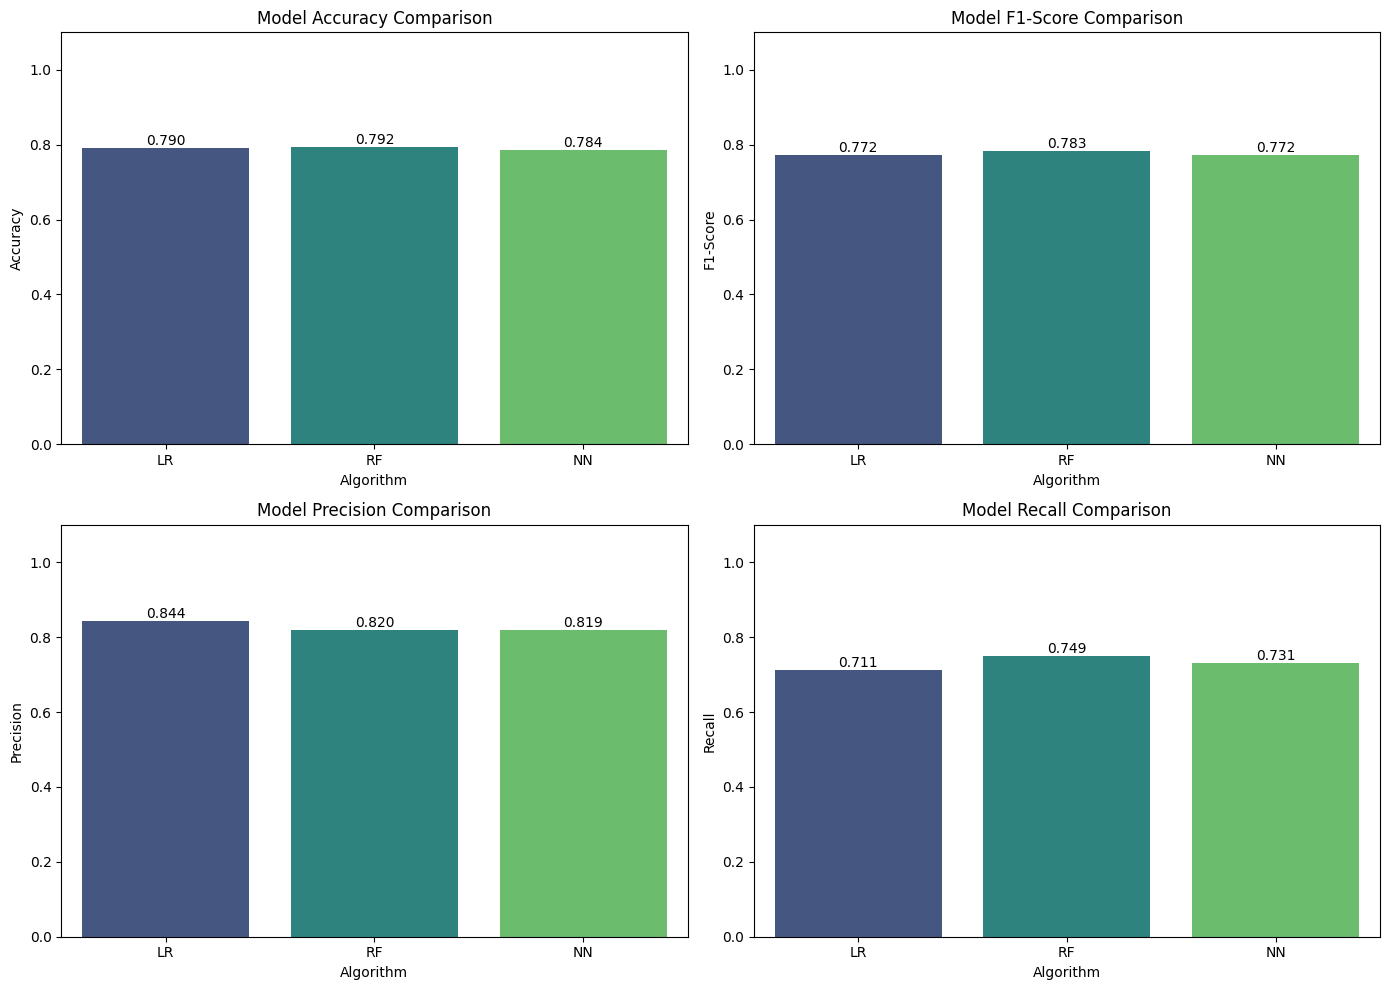

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

records = []
classes = le.classes_ # ['Not Hotspot', 'Hotspot']

for algo_name, proba in all_probas.items():
    y_pred = np.argmax(proba, axis=1)
    cm = confusion_matrix(y_resampled_test, y_pred)
    tn, fp, fn, tp = cm.ravel()
    
    records.append({
        'Algorithm': algo_name,
        'Accuracy': (tp + tn) / (tp + tn + fp + fn),
        'F1-Score': 2 * tp / (2 * tp + fp + fn),
        'Precision': tp / (tp + fp) if (tp + fp) > 0 else 0,
        'Recall': tp / (tp + fn) if (tp + fn) > 0 else 0
    })

df_perf = pd.DataFrame(records)

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
metrics = ['Accuracy', 'F1-Score', 'Precision', 'Recall']

for i, metric in enumerate(metrics):
    ax = axes[i//2, i%2]
    sns.barplot(data=df_perf, x='Algorithm', y=metric, palette='viridis', ax=ax)
    ax.set_title(f'Model {metric} Comparison')
    ax.set_ylim(0, 1.1)
    for container in ax.containers:
        ax.bar_label(container, fmt='%.3f')

plt.tight_layout()
plt.show()

## RF Feature Importance

In [25]:
import matplotlib.pyplot as plt

plt.rcParams['font.family'] = ['Heiti TC']
plt.rcParams['axes.unicode_minus'] = False 

/var/folders/w2/_g9w5yys0f171q4qqm469z1h0000gn/T/ipykernel_48706/677636575.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_imp.head(15), x='Importance', y='Feature', palette='magma')


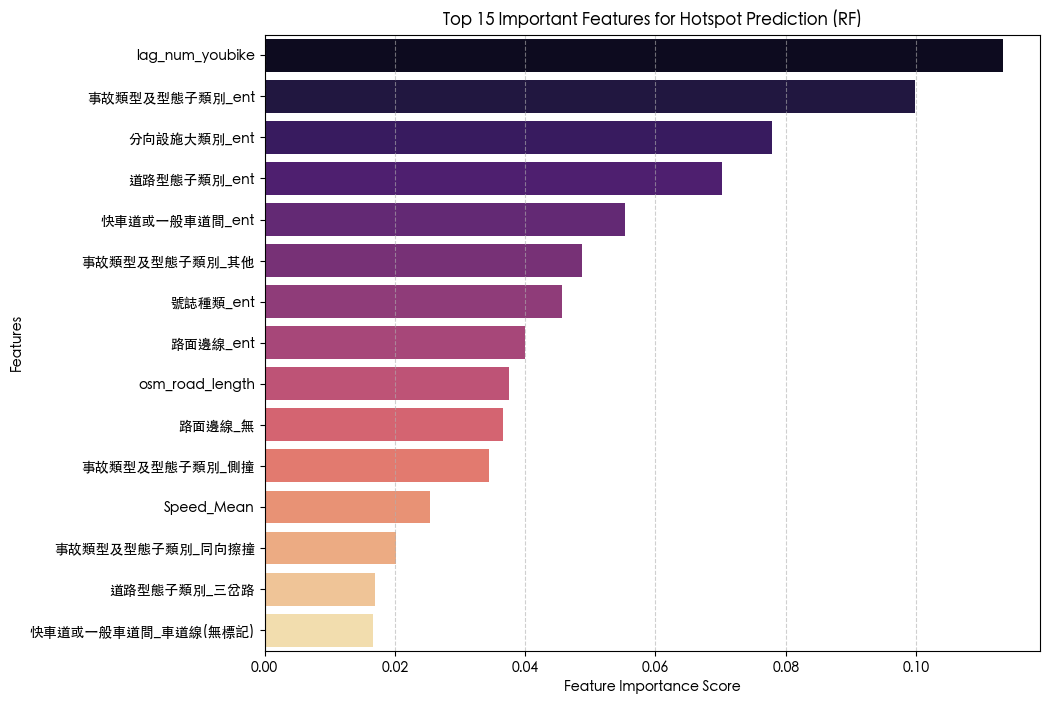

In [26]:
importances = rf_model.feature_importances_
feature_names = X_train.columns

df_imp = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(data=df_imp.head(15), x='Importance', y='Feature', palette='magma')
plt.title('Top 15 Important Features for Hotspot Prediction (RF)')
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.show()

/var/folders/w2/_g9w5yys0f171q4qqm469z1h0000gn/T/ipykernel_48706/1980288803.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_bottom_features, x='Coefficient', y='Feature', palette=colors)


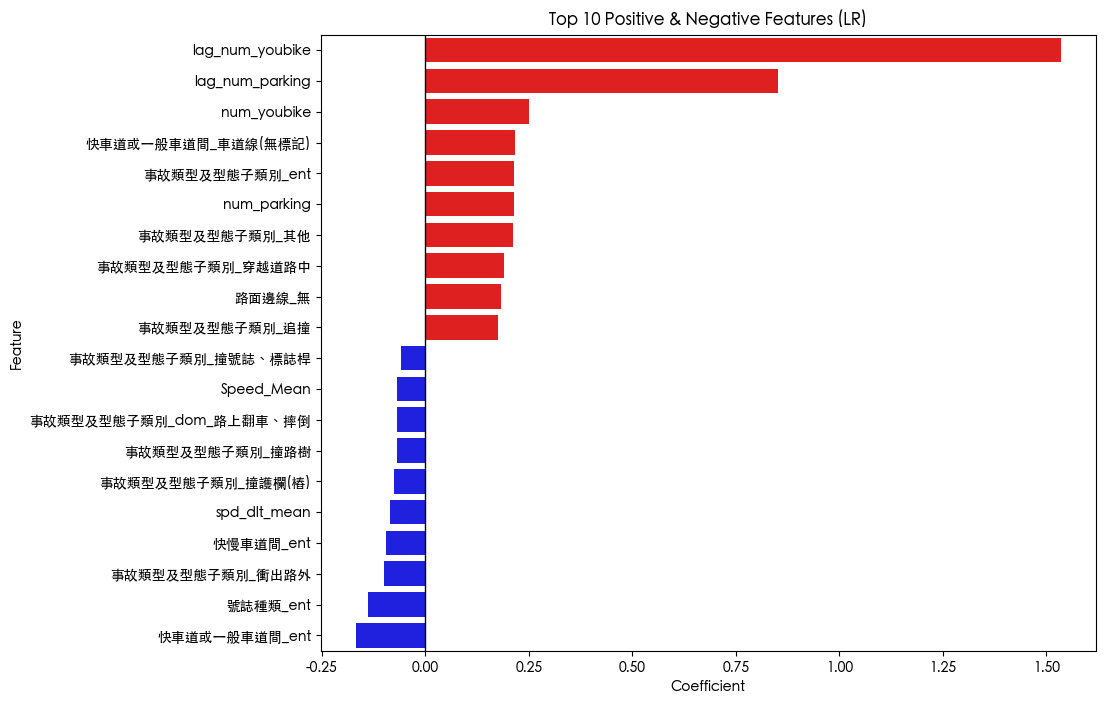

In [27]:
lr_coefs = lr_model.coef_[0]
df_lr_imp = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': lr_coefs
}).sort_values(by='Coefficient', ascending=False)

top_bottom_features = pd.concat([df_lr_imp.head(10), df_lr_imp.tail(10)])

plt.figure(figsize=(10, 8))
colors = ['red' if x > 0 else 'blue' for x in top_bottom_features['Coefficient']]
sns.barplot(data=top_bottom_features, x='Coefficient', y='Feature', palette=colors)
plt.title('Top 10 Positive & Negative Features (LR)')
plt.axvline(0, color='black', lw=1)
plt.show()